In [2]:
%load_ext autoreload

In [3]:
import numpy as np
from functools import partial
import visualization_utils as vis_utils
from iris_plant_visualizer import IrisPlantVisualizer
import ipywidgets as widgets
from IPython.display import display
from scipy.linalg import block_diag
import matplotlib.pyplot as plt
from pathlib import Path
import os
import seaborn as sns
import pandas as pd

In [4]:
#pydrake imports
from pydrake.common import FindResourceOrThrow
from pydrake.multibody.parsing import Parser
from pydrake.multibody.plant import AddMultibodyPlantSceneGraph
from pydrake.systems.framework import DiagramBuilder
from pydrake.geometry import Role, GeometrySet, CollisionFilterDeclaration
from pydrake.all import RigidTransform, RollPitchYaw, RevoluteJoint
from pydrake.all import RotationMatrix,MeshcatVisualizer, StartMeshcat
import pydrake.symbolic as sym
from pydrake.solvers import MosekSolver, CommonSolverOption, SolverOptions, ScsSolver
from pydrake.all import PointCloud, MeshcatVisualizerParams, Role, HalfSpace, CoulombFriction, Box, Rgba, WeldJoint, GeometrySet
from pydrake.polynomial import Polynomial as PolynomialCommon
import time
from scipy.spatial.transform import Rotation as sp_rot
from sampling_based_motion_planners import StraightLineCollisionChecker, PRM, BiRRT, PRMFixedEdges


from pydrake.all import (RationalForwardKinematics, ModelInstanceIndex,
                         SpatialInertia, RevoluteJoint, FixedOffsetFrame, MultibodyPlant)
from pydrake.geometry.optimization import HPolyhedron, Hyperellipsoid
from pydrake.geometry.optimization_dev import CspaceFreePath
import pickle


In [5]:
import logging
drake_logger = logging.getLogger("drake")
drake_logger.setLevel(logging.DEBUG)

In [6]:
from n_link_pendulum_stat_collector import num_links, num_boxes, num_edges, n_list, k_list, path_to_prm_save_folder, path_to_data_save_folder

In [7]:
def make_stat_path(n,k,l,use_good_checker):
    good_checker = "good_checker" if use_good_checker else "bad_checker"
    return path_to_data_save_folder /  f"{n}_links_{k}_obstacles_{l}_edges_{good_checker}_collision_checker.pkl"

In [8]:
n = 2
k = 10
l = 500
path = make_stat_path(n,k,l,True)
path.is_file()
with open(path, "rb") as f:
    statistics = pickle.load(f)

In [9]:
def get_total_time_to_solve_progs_for_n_links_k_box_l_edges(n,k,l, good_checker = True):
    path = make_stat_path(n,k,l,good_checker)
    if path.is_file():
        with open(path, "rb") as f:
            statistics = pickle.load(f)
            return np.array([s.total_time_to_solve_progs() for s in statistics])/os.cpu_count()
    else:
        return np.array([-1] * l)

def get_certified_safe_for_n_links_k_box_l_edges(n,k,l, good_checker = True):
    path = make_stat_path(n,k,l,good_checker)
    if path.is_file():
        with open(path, "rb") as f:
            statistics = pickle.load(f)
            return int(statistics.certified_safe)
    else:
        return -1

(12,)


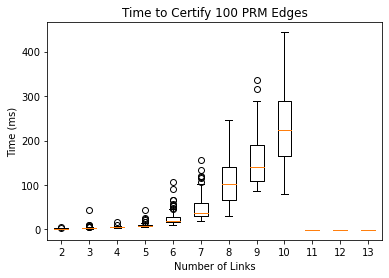

In [10]:
total_prog_solve_times_good = [
    [[get_total_time_to_solve_progs_for_n_links_k_box_l_edges(n,k,l, True) for l in num_edges] for k in num_boxes] for n in num_links
]


x = num_links
for i, l in enumerate(num_edges):
    fig, ax = plt.subplots(1)
    print(num_links.shape)
    box_data = [[total_prog_solve_times_good[n][j][i] for n in range(len(num_links))] for j in range(len(num_boxes))]
    for j in range(len(num_boxes)):
        ax.boxplot(box_data[j], labels=x, vert= True, )#, labels = f"{j} Obstacles")
        ax.set_xlabel("Number of Links")
        ax.set_ylabel("Time (ms)")
        ax.set_title(f"Time to Certify {num_edges[i]} PRM Edges")
    
#     fig.legend()
        



(12,)


KeyError: 0

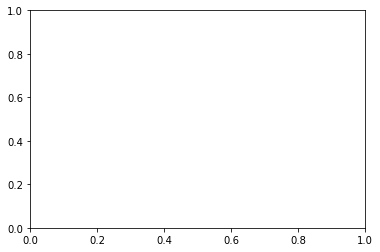

In [11]:
total_prog_solve_times_good = [
    pd.DataFrame([[get_total_time_to_solve_progs_for_n_links_k_box_l_edges(n,k,l, True) for k in num_boxes]
                  for n in num_links], index=num_links, columns= num_boxes)
    for l in num_edges
    
]



x = num_links
for i, l in enumerate(num_edges):
    fig, ax = plt.subplots(1)
    print(num_links.shape)
    sns.boxplot(total_prog_solve_times_good[i][10], ax = ax)#, labels = f"{j} Obstacles")
    ax.set_xlabel("Number of Links")
    ax.set_ylabel("Time (ms)")
    ax.set_title(f"Time to Certify {num_edges[i]} PRM Edges")
    

        



In [183]:
num_edges = np.array([100,500,1000])
def get_total_time_to_solve_progs_as_pd(good_checker = True):
    df = pd.DataFrame(columns = ["number of links", "number of boxes", "number of edges", "edge_num", "time (ms)", "successfully solved"])
    for n in num_links:
        for k in num_boxes:
            for l in num_edges:
                path = make_stat_path(n,k,l,good_checker)
                arr = None
                if path.is_file():
                    with open(path, "rb") as f:
                        statistics = pickle.load(f)
                        arr= np.array([s.total_time_to_solve_progs() for s in statistics])/os.cpu_count()
                        success = np.array([s.certified_safe() for s in statistics])
                else:
                    arr= np.array([-1] * l)
                    success = np.array([-1] * l)
                for idx,t in enumerate(arr):
                    df.loc[len(df.index)] = [n,k,l,idx,t, success[idx]] 
    return df
# get_total_time_to_solve_progs_as_pd()

In [184]:
df = get_total_time_to_solve_progs_as_pd()
print(df)

      number of links number of boxes number of edges edge_num  time (ms)  \
0                   2              10             100        0   6.640203   
1                   2              10             100        1   1.850855   
2                   2              10             100        2   1.648060   
3                   2              10             100        3   1.706826   
4                   2              10             100        4   1.891045   
...               ...             ...             ...      ...        ...   
19195              13              10            1000      995  -1.000000   
19196              13              10            1000      996  -1.000000   
19197              13              10            1000      997  -1.000000   
19198              13              10            1000      998  -1.000000   
19199              13              10            1000      999  -1.000000   

      successfully solved  
0                    True  
1                  

<AxesSubplot:xlabel='number of links', ylabel='time (ms)'>

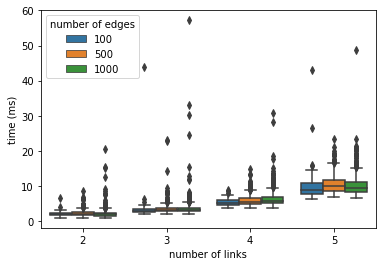

In [196]:
hundred_edge_data_successfully_solved = hundred_edge_data[hundred_edge_data["successfully solved"] != -1]
successfully_solved_data = df[df["successfully solved"] == True]
successfully_solved_deg_leq_6 = successfully_solved_data[successfully_solved_data["number of links"] < 6]


sns.boxplot(data=successfully_solved_deg_leq_6,
            x="number of links", y="time (ms)", hue="number of edges")

# for i, array in enumerate(df[num_boxes]):
#     plt.figure(figsize=(6, 4))  # Adjust the figure size as needed
#     sns.boxplot(data=df, x="num_links", y="time", hue="num_boxes")
#     plt.title(f'Box Plot for Entry {i}')
#     plt.xlabel('X-axis Label')
#     plt.ylabel('Y-axis Label')
#     plt.show()

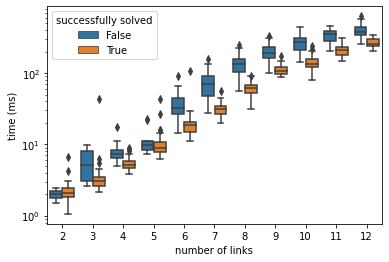

In [201]:
hundred_edge_data = df[df["number of edges"] == 100]
hundred_edge_10_boxes = hundred_edge_data[hundred_edge_data["number of boxes"] == 10]
hundred_edge_data_actually_solved = hundred_edge_10_boxes[hundred_edge_10_boxes["successfully solved"] != -1]
ax = sns.boxplot(data=hundred_edge_data_actually_solved, x="number of links", y="time (ms)", hue="successfully solved")
ax.set_yscale('log')

    True  False
2   0.98   0.02
3   0.92   0.08
4   0.84   0.16
5   0.90   0.10
6   0.65   0.35
7   0.56   0.44
8   0.37   0.63
9   0.47   0.53
10  0.27   0.73


Text(0, 0.5, 'Percent Solved')

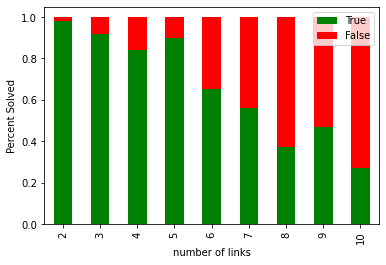

In [169]:
value_counts = hundred_edge_data_successfully_solved.groupby(['number of links'])["successfully solved"].value_counts()/100
data = np.zeros((num_links[:9].shape[0], 2))
for (n, val) in value_counts.axes[0]:
    r = np.where(num_links ==n)[0].item()
    c = 0 if val else 1
    data[r,c] = value_counts[(n,val)]
tf_counts_frame = pd.DataFrame(data=data, index=num_links[:9], columns = [True, False])
print(tf_counts_frame)
ax = tf_counts_frame.plot.bar(stacked=True, color = ['green', 'red'])
ax.set_xlabel("number of links")
ax.set_ylabel("Percent Solved")

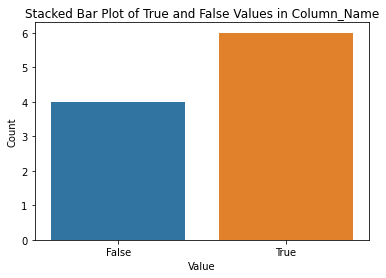

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Sample data in a DataFrame format
data = {
    'Column_Name': [True, False, True, False, True, True, False, False, True, True]
}

df = pd.DataFrame(data)

# Calculate the counts of True and False values
value_counts = df['Column_Name'].value_counts().reset_index()
value_counts.columns = ['Value', 'Count']

# Create a stacked bar plot using Seaborn
plt.figure(figsize=(6, 4))
sns.barplot(data=value_counts, x='Value', y='Count')
plt.xlabel('Value')
plt.ylabel('Count')
plt.title('Stacked Bar Plot of True and False Values in Column_Name')
plt.show()

In [59]:
n = 2
k = 100
plant, scene_graph, diagram, cspace_free_path = build_n_link_k_boxes_plant_and_certifier(n,k)
diagram_context = diagram.CreateDefaultContext()
diagram.ForcedPublish(diagram_context)

NameError: name 'build_n_link_k_boxes_plant_and_certifier' is not defined

In [11]:
q_star = np.zeros(plant.num_positions())
Ratfk = RationalForwardKinematics(plant)
diagram_col_context = diagram.CreateDefaultContext()
plant_col_context = diagram.GetMutableSubsystemContext(plant, diagram_col_context)
scene_graph_col_context = diagram.GetMutableSubsystemContext(
        scene_graph, diagram_col_context
    )
query_port = scene_graph.get_query_output_port()

def check_collision_q_by_query(q):
    if np.all(q >= plant.GetPositionLowerLimits()) and np.all(
        q <= plant.GetPositionUpperLimits()
    ):
        plant.SetPositions(plant_col_context, q)
        query_object = query_port.Eval(scene_graph_col_context)
        return 1 if query_object.HasCollisions() else 0
    else:
        return 1

def check_collision_s_by_query(s):
    s = np.array(s)
    q = Ratfk.ComputeQValue(s, q_star)
    return check_collision_q_by_query(q)

def sample_col_free_point():
    q = np.random.uniform(
        plant.GetPositionLowerLimits(), plant.GetPositionUpperLimits()
    )
    s = Ratfk.ComputeSValue(q, q_star)
    return s
l = 100
collision_checker = StraightLineCollisionChecker(
                    check_collision_s_by_query, 100
                )
prm = PRMFixedEdges(
                sample_col_free_point, l, collision_checker, dist_thresh=100
            )
diagram_vis_context = diagram.CreateDefaultContext()
plant_vis_context = diagram.GetMutableSubsystemContext(plant, diagram_vis_context)
vis_bundle = vis_utils.VisualizationBundle(
    diagram, diagram_context, plant, plant_vis_context,
    Ratfk, meshcat, q_star
)
end_effector = plant.GetBodyByName(f"link_{n}")

prm.draw_tree(vis_bundle, end_effector)

PRM has 40 nodes
PRM has 100 edges


In [14]:
len(prm.prm.edges)

100

In [27]:
import pickle
with open("tmp.pkl", "wb") as f:
    pickle.dump(prm,f)
with open("tmp.pkl", "rb") as f:
    ret = pickle.load(f)

lst = [1,2,4,3]
lst.sort()
print(lst)

[1, 2, 3, 4]


In [ ]:
meshcat.Delete()
builder = DiagramBuilder()
plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.001)

visualizer = MeshcatVisualizer.AddToBuilder(
    builder, scene_graph, meshcat)

link_dimensions = (0.1, 0.2, 0.001)
pendulum_box = Box(*link_dimensions)
pendulum_inertia = SpatialInertia.SolidBoxWithDensity(1, *link_dimensions)
pendulum_model_instance = plant.AddModelInstance("pendulum")
def AddPendulumLink(parent_frame, link_index: int, color = np.array([1,0,0,1])):
    link_name = f"link_{link_index}"
    pend_body = plant.AddRigidBody(link_name, pendulum_model_instance, pendulum_inertia)
    parent_to_child_attach_frame = plant.AddFrame(
        FixedOffsetFrame(f"{link_name}_joint_frame", pend_body.body_frame(), 
                                  RigidTransform(p = (0,link_dimensions[1]/2, 0)))
    )
    next_frame = plant.AddFrame(
        FixedOffsetFrame(f"{link_name}_joint_frame", pend_body.body_frame(), 
                                  RigidTransform(p = (0,-link_dimensions[1]/2, 0)))
    )
    # add the revolute joint,
    joint_lim = np.pi
    plant.AddJoint(RevoluteJoint(
        f"joint_{link_index}", parent_frame, parent_to_child_attach_frame, [0,0,1],
        -joint_lim, joint_lim,
    )
    )
    
    geom_id = plant.RegisterCollisionGeometry(pend_body, RigidTransform(),
                                    pendulum_box, link_name, CoulombFriction())
    plant.RegisterVisualGeometry(pend_body, RigidTransform(),
                                pendulum_box, link_name, color)
    
    
    
    return next_frame, geom_id

def N_Link_Pendulum(n: int):
    assert n > 0
    parent_frame = plant.world_frame()
    colors = np.array(vis_utils.n_colors(n))/255
    colors = np.hstack([colors,np.ones((colors.shape[0],1))])
    geom_ids = []
    for i in range(n):
        parent_frame, geom_id = AddPendulumLink(parent_frame, i+1, colors[i])
        geom_ids.append(geom_id)

    return geom_ids
        
obstacle_model_instance = plant.AddModelInstance("obstacle")
def AddRandomBox(index: int, pos_limits, size_limits, color = [0,0,0,1]):
    link_name = f"obstacle_{index}"     
    
    center = np.append(np.random.uniform(pos_limits[0],pos_limits[1], 2),0)
        
    dimensions = np.append(np.random.uniform(size_limits[0],size_limits[1],2),0.001)
    box = Box(*dimensions)
    inertia = SpatialInertia.SolidBoxWithDensity(1, *dimensions)
    
    body = plant.AddRigidBody(link_name, obstacle_model_instance, inertia)
    
    random_rp = np.zeros(3)
    lim = np.pi/10
    random_rp[2] = np.random.uniform(-lim, lim)
    angle = RotationMatrix(RollPitchYaw(random_rp))
    pose = RigidTransform(p=center)@RigidTransform(R=angle)
    origin_local = pose.inverse()@RigidTransform()
    while np.all([-dimensions[i]/2 <= origin_local.translation()[i] < dimensions[i]/2 for i in range(3)]): 
        random_rp[2] = np.random.uniform(-lim, lim)
        angle = RotationMatrix(RollPitchYaw(random_rp))
        pose = RigidTransform(p=center)@RigidTransform(R=angle)
        origin_local = pose.inverse()@RigidTransform()
    plant.AddJoint(WeldJoint(link_name, plant.world_frame(), body.body_frame(),
                            pose))
    plant.RegisterCollisionGeometry(body, RigidTransform(),
                                    box, link_name, CoulombFriction())
    plant.RegisterVisualGeometry(body, RigidTransform(),
                                box, link_name, color)
    
    

def AddNRandomBoxes(n: int, pos_limits=(-10,10),
                    size_limits = (0.1,1), color= [0,0,0,1],
                   filter_all = False):
    assert n > 0
    for i in range(n):
        AddRandomBox(i, pos_limits, size_limits, color)

# child_frame = AddPendulumLink(plant.world_frame(), 1)
num_pend = 3
num_obstacles = 4
np.random.seed(num_pend * num_obstacles)


pend_geom_ids = N_Link_Pendulum(num_pend)

obstacle_pos_limits = link_dimensions[1]*num_pend*np.array([-1,1])
obstacle_size_limits = (0.01/np.log(num_obstacles),0.5/np.log(num_obstacles))
AddNRandomBoxes(num_obstacles, obstacle_pos_limits, obstacle_size_limits)


plant.Finalize()

end_effector = plant.GetBodyByName(f"link_{num_pend}")

def SetMeshcatPerspective2d(meshcat_instance, X_WC):
    meshcat_instance.SetTransform("/Cameras/default", X_WC)
    meshcat_instance.SetProperty("/Background", "visible", False);
    meshcat_instance.SetProperty("/Grid", "visible", False);
    meshcat_instance.SetProperty("/Axes", "visible", False)

SetMeshcatPerspective2d(meshcat, RigidTransform(p=np.array([0,0,1])))
# meshcat.Set2dRenderMode(RigidTransform(p=np.array([0,0,1])))

diagram = builder.Build()
diagram_context = diagram.CreateDefaultContext()
plant_context = diagram.GetMutableSubsystemContext(plant, diagram_context)
scene_graph_context = diagram.GetMutableSubsystemContext(scene_graph, diagram_context)
query_port = scene_graph.get_query_output_port()
diagram.ForcedPublish(diagram_context)

q_star = np.zeros(plant.num_positions())
Ratfk = RationalForwardKinematics(plant)

diagram_vis_context = diagram.CreateDefaultContext()
plant_vis_context =  diagram.GetMutableSubsystemContext(plant, diagram_vis_context)
vis_bundle = vis_utils.VisualizationBundle(
    diagram, diagram_vis_context, plant, plant_vis_context,
    Ratfk, meshcat, q_star
)

In [7]:
#compute limits in s-space
limits_s = []
lower_q = plant.GetPositionLowerLimits()
upper_q = plant.GetPositionUpperLimits()

for q in [lower_q,upper_q]:
    limits_s.append(Ratfk.ComputeSValue(np.array(q), q_star))
limits_s = np.array(limits_s)
print(limits_s)

[[-1.63312394e+16 -1.63312394e+16 -1.63312394e+16]
 [ 1.63312394e+16  1.63312394e+16  1.63312394e+16]]


In [8]:
from pydrake.all import InverseKinematics
ik = InverseKinematics(plant, diagram.GetMutableSubsystemContext(plant, diagram_context))
min_dist = 1e-5
collision_constraint = ik.AddMinimumDistanceConstraint(
            min_dist, 1e-5)
diagram_col_context = diagram.CreateDefaultContext()
plant_col_context = diagram.GetMutableSubsystemContext(plant, diagram_col_context)
scene_graph_col_context = diagram.GetMutableSubsystemContext(scene_graph, diagram_col_context)
def check_collision_q_by_ik(q, min_dist=1e-5):
    if np.all(q >= plant.GetPositionLowerLimits()) and \
            np.all(q <= plant.GetPositionUpperLimits()):
        return 1 - 1 * \
            float(collision_constraint.evaluator().CheckSatisfied(q, min_dist))
    else:
        return 1
def check_collision_s_by_ik(s, min_dist=1e-5):
    s = np.array(s)
    q = Ratfk.ComputeQValue(s, q_star)
    return check_collision_q_by_ik(q, min_dist)

def check_collision_q_by_query(q):
    if np.all(q >= plant.GetPositionLowerLimits()) and \
            np.all(q <= plant.GetPositionUpperLimits()):
        plant.SetPositions(plant_col_context, q)
        query_object = query_port.Eval(scene_graph_col_context)
        return 1 if query_object.HasCollisions() else 0
    else:
        return 1
    
def check_collision_s_by_query(s):
    s = np.array(s)
    q = Ratfk.ComputeQValue(s, q_star)
    return check_collision_q_by_query(q)

## Set up the sliders so we can move the plant around manually

In [18]:
sliders = []
diagram_context = diagram.CreateDefaultContext()
plant_context = diagram.GetMutableSubsystemContext(plant, diagram_context)
for i in range(plant.num_positions()):
    sliders.append(widgets.FloatSlider(min=plant.GetPositionLowerLimits()[i],
                                       max=plant.GetPositionUpperLimits()[i], 
                                       value=plant.GetPositions(plant_context)[i],
                                       description=f'q{i}'))
# sliders.append(widgets.FloatSlider(min=q_low[2], max=q_high[2], value=0, description='q2'))

q = np.zeros(plant.num_positions())
def handle_slider_change(change, idx):
    q[idx] = change['new']
    plant.SetPositions(plant_context, q)
    diagram.ForcedPublish(diagram_context)

    
idx = 0
for slider in sliders:
    slider.observe(partial(handle_slider_change, idx = idx), names='value')
    idx+=1

for slider in sliders:
    display(slider)


# visualizer.jupyter_cell()

FloatSlider(value=0.0, description='q0', max=3.141592653589793, min=-3.141592653589793)

FloatSlider(value=0.0, description='q1', max=3.141592653589793, min=-3.141592653589793)

FloatSlider(value=0.0, description='q2', max=3.141592653589793, min=-3.141592653589793)

FloatSlider(value=0.0, description='q3', max=3.141592653589793, min=-3.141592653589793)

FloatSlider(value=0.0, description='q4', max=3.141592653589793, min=-3.141592653589793)

DEBUG:drake:Meshcat connection closed from 0000:0000:0000:0000:0000:0000:0000:0001


In [10]:
col_checker = StraightLineCollisionChecker(check_collision_s_by_query, 100)
def sample_col_free_point():
    q = np.random.uniform(plant.GetPositionLowerLimits(), plant.GetPositionUpperLimits())
    s = Ratfk.ComputeSValue(q, q_star)
    return s
np.random.seed(0)
prm = PRMFixedEdges(sample_col_free_point,
         100,
         col_checker,
         dist_thresh = 100)
prm.draw_tree(vis_bundle, end_effector)

PRM: Num edges = 27/100
PRM: Num nodes = 10

PRM: Num edges = 66/100
PRM: Num nodes = 20

PRM: Num edges = 100/100
PRM: Num nodes = 30

PRM has 30 nodes
PRM has 100 edges


In [11]:
def make_line_polys(prm, max_num_edges = -1):
    
    polys = np.empty(shape=(plant.num_positions(), 
                            len(prm.prm.edges()) if max_num_edges < 0 else max_num_edges), dtype = object)
    for i, (s0, s1) in enumerate(prm.prm.edges()):
        for j in range(plant.num_positions()):
            if max_num_edges > 0 and not i < max_num_edges:
                break
            polys[j,i] = PolynomialCommon(np.array([s0[j],s1[j]-s0[j]]))
        
    return polys

path_safe = make_line_polys(prm,500)
# path_unsafe = make_line_polys(PRM_bad)
    

In [12]:
# The object we will use to perform our certification.
t0 = time.time()
cspace_free_path = CspaceFreePath(plant, scene_graph, q_star,
                                  maximum_path_degree = 1, 
                                  plane_order = 1)
t1 = time.time()
print(f"Time to construct line certifier = {t1-t0}s")


cert_options = CspaceFreePath.FindSeparationCertificateGivenPathOptions()
cert_options.terminate_segment_certification_at_failure = False

cert_options.num_threads = -1
cert_options.verbose = False
cert_options.solver_id = MosekSolver.id()
cert_options.solver_options = SolverOptions()
cert_options.terminate_path_certification_at_failure = False


Time to construct line certifier = 0.049834489822387695s


In [17]:
print(len(cspace_free_path.separating_planes()))

13


In [22]:
from pydrake.all import GeometrySet, CollisionFilterDeclaration
collision_filter_manager = scene_graph.collision_filter_manager()
pend_geom_set = GeometrySet(pend_geom_ids)
decl = CollisionFilterDeclaration().ExcludeWithin(pend_geom_set)
collision_filter_manager.Apply(decl)
t0 = time.time()
cspace_free_path2 = CspaceFreePath(plant, scene_graph, q_star,
                                  maximum_path_degree = 1, 
                                  plane_order = 1)
t1 = time.time()
print(f"Time to construct line certifier = {t1-t0}s")
print(len(cspace_free_path2.separating_planes()))

Time to construct line certifier = 0.04575467109680176s
12


In [23]:
ignored_collision_pairs = set()
for g1 in pend_geom_ids[:-1]:
    for g2 in pend_geom_ids[1:]: 
        ignored_collision_pairs.add((g1,g2))

In [24]:
t0 = time.time()
statistics, cert_result = \
    cspace_free_path2.FindSeparationCertificateGivenPath(path_safe, 
                                                        ignored_collision_pairs,
                                                        cert_options)
t1 = time.time()
print(f"Certification of safe PRM in {t1-t0}s")

Certification of safe PRM in 5.007325887680054s


In [ ]:
solve_times = np.array([list(s.time_to_solve_prog.values()) for s in statistics])
build_times = np.array([list(s.time_to_build_prog.values()) for s in statistics])
total_times = np.array([list(s.total_time_to_certify_pair.values()) for s in statistics])


In [ ]:
fig, ax = plt.subplots(1,3)
ax[0].stairs(*np.histogram(solve_times))
ax[0].set_title('program solve times')
ax[1].stairs(*np.histogram(build_times))
ax[1].set_title('program build times')
ax[2].stairs(*np.histogram(total_times))
ax[2].set_title('pair certification time')

In [ ]:
plt.stairs(*np.histogram(solve_times))
plt.title(f'Distribution of solve times for pairs, {num_pend} links, {num_obstacles} obstacles')
plt.xlabel("ms")
plt.ylabel("number of pairs")

In [ ]:
import os
num_cores = os.cpu_count()
print(num_cores)
total_prog_solve_times = np.array([s.total_time_to_solve_progs()/num_cores for s in statistics])
plt.stairs(*np.histogram(total_prog_solve_times))
plt.title(f'Total Certification Times PRM Edges, {num_pend} links, {num_obstacles} obstacles {500} edges')
plt.xlabel("ms")
plt.ylabel("number of edges requiring time")

In [ ]:
import pickle
with open("tmp.pkl", "wb") as f:
    pickle.dump(statistics[0], f)

In [ ]:
with open("tmp.pkl", "rb") as f:
    tmp = pickle.load(f)

In [ ]:
total_prog_solve_times.shape

In [ ]:
def plot_pair_safety(pairs, statistics, body,
                                    path_size = 0.01, num_points = 1000, prefix = "prm"):
    meshcat.Delete(f"{prefix}_safe")
    meshcat.Delete(f"{prefix}_unsafe")
    
    safe_options = vis_utils.TrajectoryVisualizationOptions(
        path_color = Rgba(0,1,0,1), path_size = path_size, num_points = num_points
    )
    unsafe_options = vis_utils.TrajectoryVisualizationOptions(
        path_color = Rgba(1,0,0,1), path_size = path_size, num_points = num_points
    )
    
    for idx, (s0, s1) in enumerate(pairs):
        s0, s1 = np.array(s0), np.array(s1)
        if statistics[idx].certified_safe():
            vis_utils.visualize_s_space_segment(vis_bundle,s0, s1, body,
                                        f"{prefix}_safe/seg_{idx}", safe_options)
        else:
            vis_utils.visualize_s_space_segment(vis_bundle,s0, s1, body, 
                                        f"{prefix}_unsafe/seg_{idx}", unsafe_options)
plot_pair_safety(prm.prm.edges(), statistics, end_effector)

In [ ]:
path_safe.shape

In [ ]:
unsafe_path = None
for idx, stats in enumerate(statistics):
    if not stats.certified_safe():
        unsafe_path = path_safe[:, idx]
col_found = False
for t in np.linspace(0, 1, int(1e3)):
    s = np.array([unsafe_path[i].EvaluateUnivariate(t) for i in range(unsafe_path.shape[0])])
    if check_collision_s_by_query(s):
        print("COLLISION FOUND")
        col_found = True
        plant.SetPositions(plant_context, Ratfk.ComputeQValue(s, q_star))
        diagram.ForcedPublish(diagram_context)
        break
print(col_found)

In [2]:
import numpy as np
num_links = np.arange(2, 12, 1)
num_boxes = np.array([10, 50, 100])
num_edges = np.array([50, 100, 1000])
good_checker = np.array([True, False])

NN, KK = np.meshgrid(num_links, num_boxes,  indexing = 'ij')
# LL,GG, NN,  KK   = np.meshgrid(num_edges,good_checker,num_links,  num_boxes, indexing = 'ij')
for i in range(NN.shape[0]):
    for j in range(NN.shape[1]):
                print(NN[i,j],KK[i,j])

2 10
2 50
2 100
3 10
3 50
3 100
4 10
4 50
4 100
5 10
5 50
5 100
6 10
6 50
6 100
7 10
7 50
7 100
8 10
8 50
8 100
9 10
9 50
9 100
10 10
10 50
10 100
11 10
11 50
11 100


2 10 50
2 50 50
2 100 50
2 10 100
2 50 100
2 100 100
2 10 1000
2 50 1000
2 100 1000
3 10 50
3 50 50
3 100 50
3 10 100
3 50 100
3 100 100
3 10 1000
3 50 1000
3 100 1000
4 10 50
4 50 50
4 100 50
4 10 100
4 50 100
4 100 100
4 10 1000
4 50 1000
4 100 1000
5 10 50
5 50 50
5 100 50
5 10 100
5 50 100
5 100 100
5 10 1000
5 50 1000
5 100 1000
6 10 50
6 50 50
6 100 50
6 10 100
6 50 100
6 100 100
6 10 1000
6 50 1000
6 100 1000
7 10 50
7 50 50
7 100 50
7 10 100
7 50 100
7 100 100
7 10 1000
7 50 1000
7 100 1000
8 10 50
8 50 50
8 100 50
8 10 100
8 50 100
8 100 100
8 10 1000
8 50 1000
8 100 1000
9 10 50
9 50 50
9 100 50
9 10 100
9 50 100
9 100 100
9 10 1000
9 50 1000
9 100 1000
10 10 50
10 50 50
10 100 50
10 10 100
10 50 100
10 100 100
10 10 1000
10 50 1000
10 100 1000
11 10 50
11 50 50
11 100 50
11 10 100
11 50 100
11 100 100
11 10 1000
11 50 1000
11 100 1000
